# Comparing ML Models and selecting the ideal one to create the playlist

In [1]:
import spotipy

import spotipy.util as util
import pandas as pd
import matplotlib.pyplot as plt

from spotipy.oauth2 import SpotifyOAuth

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

In [2]:
%load_ext autoreload
%autoreload 1
%aimport spotify_credentials
#loads spotify_credentials.py file

In [3]:
client_id = spotify_credentials.client_id
client_secret = spotify_credentials.client_secret
username = spotify_credentials.username
scope = "user-library-read user-follow-read user-top-read playlist-read-private" 
redirect_uri = spotify_credentials.redirect_uri
                                                      
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=client_id,
    client_secret=client_secret,
    redirect_uri=redirect_uri,
    scope=scope,
))

## Loading and Preparing Data

In [4]:
playlist_df = pd.read_pickle("./playlist_tracks_new.pkl")
recommendation_df = pd.read_pickle("./recommendation_tracks_new.pkl")
#Read pickled dataframes from music_data.py

In [7]:
playlist_df = playlist_df.drop_duplicates(subset='id', keep="first").reset_index()
recommendation_df = recommendation_df.drop_duplicates(subset='id', keep="first").reset_index()
recommendation_df = recommendation_df[~recommendation_df['id'].isin(playlist_df['id'].tolist())]
#Remove duplicates within and between the two dataframes, to avoid data leakage

In [8]:
playlist_df.head()

,index,id,name,popularity,type,is_local,explicit,duration_ms,artist_id,artist_name,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
0,0,0yBAs3atBwf2L4nvKYhN05,Doombringer,9,audio_features,False,False,172221,0jOyRSI9FcV0dxbjbj2ZlB,Revolve,...,0.1540,0.000044,0.022300,0.2510,0.0485,107.880,spotify:track:0yBAs3atBwf2L4nvKYhN05,https://api.spotify.com/v1/tracks/0yBAs3atBwf2...,https://api.spotify.com/v1/audio-analysis/0yBA...,4
1,1,1wuhKUZzrWny2pMSInKBqm,Death Pledge,6,audio_features,False,False,201694,0jOyRSI9FcV0dxbjbj2ZlB,Revolve,...,0.1540,0.000143,0.000053,0.0741,0.1270,95.123,spotify:track:1wuhKUZzrWny2pMSInKBqm,https://api.spotify.com/v1/tracks/1wuhKUZzrWny...,https://api.spotify.com/v1/audio-analysis/1wuh...,3
2,2,1jXU0PEPtxtCRVlIY99sMn,The Ice in My Veins,7,audio_features,False,False,120308,0jOyRSI9FcV0dxbjbj2ZlB,Revolve,...,0.1710,0.000264,0.011400,0.3390,0.1120,200.745,spotify:track:1jXU0PEPtxtCRVlIY99sMn,https://api.spotify.com/v1/tracks/1jXU0PEPtxtC...,https://api.spotify.com/v1/audio-analysis/1jXU...,3
3,3,0kdbzYWe7cfhVXUxd5neCX,Dragged into Extinction,5,audio_features,False,False,227130,0jOyRSI9FcV0dxbjbj2ZlB,Revolve,...,0.1820,0.000403,0.000181,0.0574,0.0457,136.495,spotify:track:0kdbzYWe7cfhVXUxd5neCX,https://api.spotify.com/v1/tracks/0kdbzYWe7cfh...,https://api.spotify.com/v1/audio-analysis/0kdb...,4
4,4,3KPjyF2DKGNM2Ztt1P2Voa,Crown Ov Scorn,7,audio_features,False,False,168594,0jOyRSI9FcV0dxbjbj2ZlB,Revolve,...,0.0983,0.000063,0.115000,0.0943,0.0993,128.892,spotify:track:3KPjyF2DKGNM2Ztt1P2Voa,https://api.spotify.com/v1/tracks/3KPjyF2DKGNM...,https://api.spotify.com/v1/audio-analysis/3KPj...,4


In [9]:
playlist_fav = ["Runmanting", "Hardcore", "N e u r o", "OLD  P O P", "RnB - Fast and Furious vviiibbeess"]
#list of favourite playlists to rate the songs in the rest of the current users playlists
playlist_fav_ids = []
playlists = sp.current_user_playlists()

playlist_data = playlists['items']
playlist_ids = []
for playlist in playlist_data:
    for i in range(playlist['tracks']['total']):
        playlist_ids.append(playlist['id'])
playlist_ids = list(dict.fromkeys(playlist_ids))

playlists = sp.user_playlists(username)
names = [playlist['name'] for playlist in playlists['items']]
for i in range(len(names)):
    if names[i] in playlist_fav:
        playlist_fav_ids.append(playlist_ids[i])

print(playlist_fav_ids)
#returns list of playlist ids from that initial named list

['1WmLzIWebDqbfSKOI0o1s0', '4w9fLU9hrvKvnMhilMGgJZ', '6faMQ5tUiRyLwCHgUfAoel', '4GHxOi3beQRFg4tJhT2ga5', '26CdqKEdYCFy7kBKiIE38g']


In [10]:
playlist_df['ratings'] = playlist_df['playlist_id'].apply(lambda x: 1 if x in playlist_fav_ids else 0)
playlist_df['ratings']
#applying a rating of 1 to songs within fave playlists, and 0 if not

0       1
1       1
2       1
3       1
4       1
       ..
5373    0
5374    0
5375    0
5376    0
5377    0
Name: ratings, Length: 5378, dtype: int64

## Defining chosen Model evaluation criteria and splitting dataset

In [11]:
X = playlist_df[['popularity', 'explicit', 'duration_ms', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'tempo', 'time_signature', 'genres']]  #order here is important for xgboost later
y = playlist_df['ratings'] #Training data


X = X.dropna()
recommendation_df = recommendation_df.dropna() #Drop any empty cells


X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
X_recommend = recommendation_df.copy()
X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())
#Create genre columns (one-hot encoding)

X = X[X.columns.intersection(X_recommend.columns)]
X_recommend = X_recommend[X_recommend.columns.intersection(X.columns)]
#Ensure features are consistent across training, test, and evaluation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Train-test split


print(y_train.value_counts())
print(y_test.value_counts())
X_train.head()

0    3428
1     874
Name: ratings, dtype: int64
0    832
1    244
Name: ratings, dtype: int64


,popularity,explicit,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,...,vaporwave,vegan straight edge,virginia metal,vocal house,vocaloid,wave,weightless,welsh hip hop,welsh indie,wonky
802,2,False,196104,0.246,0.881,9,-5.259,1,0.1120,0.000632,...,0,0,0,0,0,0,0,0,0,0
5194,23,False,195440,0.444,0.906,11,-3.998,0,0.0865,0.000825,...,0,0,0,0,0,0,0,0,0,0
1779,25,False,271934,0.495,0.815,7,-4.890,0,0.0396,0.000348,...,0,0,0,0,0,0,0,0,0,0
5146,13,True,210000,0.336,0.980,10,-4.916,0,0.1260,0.000068,...,0,0,0,0,0,0,0,0,0,0
3428,47,False,397440,0.273,0.576,2,-11.070,1,0.0590,0.042600,...,0,0,0,0,0,0,0,0,0,0


## Oversampling Dataset
Since there is a big variety into the number of 1s and 0s in the dataset, as seen in the y_train values above, it might be good to compare oversampling the dataset to reduce this difference and see whether it increases model performance.

In [12]:
oversample = SMOTE(random_state=42)
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

print(y_train_os.value_counts())
print(y_test.value_counts())

0    3428
1    3428
Name: ratings, dtype: int64
0    832
1    244
Name: ratings, dtype: int64


## Analysing the Importance of a Feature

In [13]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth=4, random_state=42)
rfc.fit(X_train, y_train)

important_features_dict = {}
for idx, val in enumerate(rfc.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

for i in range(len(important_features_list[:50])):
    print(f"{i+1}. {X_train.columns[important_features_list[i]]} {important_features_dict[important_features_list[i]]}")
#prints my top 50 most important features

1. metallic hardcore 0.09397912168941504
2. dance pop 0.0871332121148058
3. uk beatdown 0.07202792535636024
4. ukhc 0.05013329278077869
5. loudness 0.04912117824727966
6. urban contemporary 0.04393745329322059
7. pop rap 0.04183766170131885
8. energy 0.041375260956056106
9. acousticness 0.029879269915712818
10. nyhc 0.02806043209061938
11. hip pop 0.02773318641267702
12. speechiness 0.026560480933466815
13. duration_ms 0.024947780754182775
14. neurofunk 0.02469227767022278
15. valence 0.022268834674945778
16. instrumentalness 0.022117906047237176
17. vegan straight edge 0.02155010913045124
18. beatdown 0.019837173796371066
19. explicit 0.018901658813952327
20. metalcore 0.018709649939987662
21. hip hop 0.018668319159227505
22. r&b 0.01803759059619618
23. europop 0.017800742124051278
24. popularity 0.013821727366867589
25. melodic metalcore 0.013780299937518727
26. danceability 0.013307151461895038
27. chaotic hardcore 0.009017941634352065
28. post-teen pop 0.008863665143493316
29. germ

Lol that explicit is apparently my 19th most important feature.

## Decision Tree Classifier (also Oversampled)

In [14]:
dtc = DecisionTreeClassifier(random_state=42)
dtc_gcv_parameters = {'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
dtc_gcv = GridSearchCV(dtc, dtc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
dtc_gcv.fit(X_train, y_train)
print(classification_report(y_test, dtc_gcv.predict(X_test)))

dtc_gcv_os = GridSearchCV(dtc, dtc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
dtc_gcv_os.fit(X_train_os, y_train_os)
print(classification_report(y_test, dtc_gcv_os.predict(X_test)))

Fitting 2 folds for each of 7 candidates, totalling 14 fits
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       832
           1       0.94      0.75      0.84       244

    accuracy                           0.93      1076
   macro avg       0.94      0.87      0.90      1076
weighted avg       0.93      0.93      0.93      1076

Fitting 2 folds for each of 7 candidates, totalling 14 fits
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       832
           1       0.60      0.86      0.71       244

    accuracy                           0.84      1076
   macro avg       0.78      0.85      0.80      1076
weighted avg       0.88      0.84      0.85      1076



## Random Forest Classifier (also Oversampled)

In [15]:
rfc = RandomForestClassifier(n_estimators = 1000, random_state=42)
rfc_gcv_parameters = {'min_samples_leaf': [1, 3, 5, 8], 
                      'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
rfc_gcv = GridSearchCV(rfc, rfc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfc_gcv.fit(X_train, y_train)
print(classification_report(y_test, rfc_gcv.predict(X_test)))

rfc_gcv_os = GridSearchCV(rfc, rfc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfc_gcv_os.fit(X_train_os, y_train_os)
print(classification_report(y_test, rfc_gcv_os.predict(X_test)))

Fitting 2 folds for each of 28 candidates, totalling 56 fits
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       832
           1       0.97      0.72      0.82       244

    accuracy                           0.93      1076
   macro avg       0.94      0.86      0.89      1076
weighted avg       0.93      0.93      0.93      1076

Fitting 2 folds for each of 28 candidates, totalling 56 fits
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       832
           1       0.74      0.87      0.80       244

    accuracy                           0.90      1076
   macro avg       0.85      0.89      0.87      1076
weighted avg       0.91      0.90      0.90      1076



## XGBoost Classifier (also Oversampled)

In [16]:
xgb = XGBClassifier(n_estimators = 1000, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_gcv_parameters = {'eta': [0.2, 0.3, 0.4, 0.5],
                      'min_child_weight': [0.3, 0.5, 0.8, 1],
                      'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
xgb_gcv = GridSearchCV(xgb, xgb_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
xgb_gcv.fit(X_train, y_train) 
print(classification_report(y_test, xgb_gcv.predict(X_test)))

xgb_gcv_os = GridSearchCV(xgb, xgb_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
xgb_gcv_os.fit(X_train_os, y_train_os)
print(classification_report(y_test, xgb_gcv_os.predict(X_test)))

Fitting 2 folds for each of 112 candidates, totalling 224 fits
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       832
           1       0.95      0.80      0.87       244

    accuracy                           0.95      1076
   macro avg       0.95      0.90      0.92      1076
weighted avg       0.95      0.95      0.94      1076

Fitting 2 folds for each of 112 candidates, totalling 224 fits
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       832
           1       0.84      0.85      0.84       244

    accuracy                           0.93      1076
   macro avg       0.90      0.90      0.90      1076
weighted avg       0.93      0.93      0.93      1076



## K Nearest Neighbours Classifier (also Oversampled)

In [17]:
knn = KNeighborsClassifier(n_jobs=-1)
knn_gcv_params = {'n_neighbors': range(1, 10)}

knn_gcv = GridSearchCV(knn, knn_gcv_params, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
knn_gcv.fit(X_train, y_train)
print(classification_report(y_test, knn_gcv.predict(X_test)))

knn_gcv_os = GridSearchCV(knn, knn_gcv_params, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
knn_gcv_os.fit(X_train_os, y_train_os)
print(classification_report(y_test, knn_gcv_os.predict(X_test)))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       832
           1       0.34      0.07      0.12       244

    accuracy                           0.76      1076
   macro avg       0.56      0.52      0.49      1076
weighted avg       0.68      0.76      0.69      1076

Fitting 2 folds for each of 9 candidates, totalling 18 fits
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       832
           1       0.25      0.39      0.31       244

    accuracy                           0.60      1076
   macro avg       0.52      0.53      0.51      1076
weighted avg       0.67      0.60      0.63      1076



## Comparing Model Performance using Confusion Matrixs based on predicted results on the test set

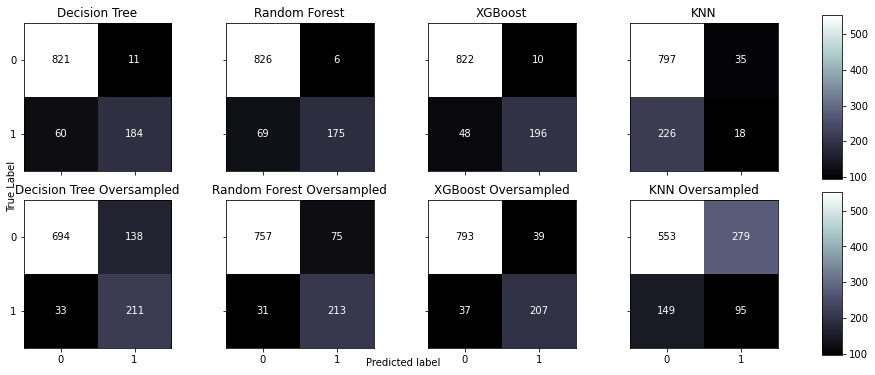

In [18]:
classifiers = { #dictionary of model names and functions
    'Decision Tree': dtc_gcv,
    'Random Forest': rfc_gcv,
    'XGBoost': xgb_gcv,
    'KNN': knn_gcv,
    'Decision Tree Oversampled': dtc_gcv_os,
    'Random Forest Oversampled': rfc_gcv_os,
    'XGBoost Oversampled': xgb_gcv_os,
    'KNN Oversampled': knn_gcv_os
}

rows=2
cols=4
fig, axes = plt.subplots(rows, cols, figsize=(12,5), sharey='row', sharex='col', constrained_layout=True)

for i, (key, classifier) in enumerate(classifiers.items()):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    y_pred = classifier.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[r][c], cmap='bone')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=8:
        disp.ax_.set_ylabel('')

fig.text(0.0, 0.5, 'True Label', va='center', rotation='vertical')
fig.text(0.415, 0, 'Predicted label', ha='left')
fig.set_constrained_layout_pads(wspace=0.1)


fig.colorbar(disp.im_, ax=axes[0, :], location='right')
fig.colorbar(disp.im_, ax=axes[1, :], location='right')

plt.show()

Since this project is about creating a playlist of new songs to discover, I think the model should prioritise the number of false negatives. This is since it'd be better to add songs to the playlist that have been predicted that I would like but I actually don't (False Positive) than the model missing out on potentially good songs.

To help decide what model (also oversampled vs no oversampling) I used a weighted design matrix!
I have ranked each model with 8 points (for the best) down to 1 (for the worst).
Another important attibute is maximising correct 1s as this will add more songs to the playlist.
Finally maximising correct 0s should prevent too many wrongly classified songs.

| | Weights | DTC | RFC | XGB | KNN | DTC OS | **RFC OS** | XGB OS | KNN OS |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Max Correct 1 | 2 | 4 | 3| 5| 1 | 7 | 8 | 6 | 2 |
| Max Flase Negatives | 3 | 4 | 3 | 5| 1 | 7 | 8 | 6 | 2 |
| Max Correct 0 | 1 | 7 | 8 | 7 | 5 | 2 | 3 | 4 | 1 |
| Total | | 27 | 23 | 32 | 10 | 37 | **43** | 34 | 11 |

Looking at this table I have chosen Random Forest Classifier Oversampled as the model to use

In [19]:
recommendation_df['ratings'] = rfc_gcv_os.predict(X_recommend) #predicting what songs recieve a 1 rating
recommendation_df['prob_ratings'] = rfc_gcv_os.predict_proba(X_recommend)[:,1]  #slice for probability of 1
recommendation_df[recommendation_df['ratings'] == 1].head()

,index,id,name,popularity,type,is_local,explicit,duration_ms,artist_id,artist_name,...,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,ratings,prob_ratings
0,0,1XSyyQjZu1mxK679G1mr7v,Slither,23,audio_features,False,False,245187,3Lrq7jnwOegUxvOYbd49fw,Brutality Will Prevail,...,0.0717,0.4480,0.2710,140.454,spotify:track:1XSyyQjZu1mxK679G1mr7v,https://api.spotify.com/v1/tracks/1XSyyQjZu1mx...,https://api.spotify.com/v1/audio-analysis/1XSy...,4,1,0.818671
1,1,06Z2FZpO0gNMf6g1lm6cfz,Veins,18,audio_features,False,False,114297,18DaTNmWI7nYhXkXQZEZev,Mortality Rate,...,0.0000,0.3210,0.0390,141.735,spotify:track:06Z2FZpO0gNMf6g1lm6cfz,https://api.spotify.com/v1/tracks/06Z2FZpO0gNM...,https://api.spotify.com/v1/audio-analysis/06Z2...,4,1,0.664523
2,2,0kfGcjWCLSaxiI7aR6r68V,IRIS (LENS OF DEPRESSION),17,audio_features,False,False,131413,2xrB9HuIJ8XYHFpgNPg1wy,Sanction,...,0.1910,0.1350,0.0403,89.810,spotify:track:0kfGcjWCLSaxiI7aR6r68V,https://api.spotify.com/v1/tracks/0kfGcjWCLSax...,https://api.spotify.com/v1/audio-analysis/0kfG...,4,1,0.834343
4,4,1ifC1L0rGhcim10gTxsOg7,Devil U Know,21,audio_features,False,False,145796,4wf6GGNBqaU79839E6yjfn,Speed,...,0.1210,0.1440,0.3180,82.268,spotify:track:1ifC1L0rGhcim10gTxsOg7,https://api.spotify.com/v1/tracks/1ifC1L0rGhci...,https://api.spotify.com/v1/audio-analysis/1ifC...,4,1,0.933507
5,5,21ueg7zt4lUjKkI3iSLntA,Memento Mori,12,audio_features,False,False,173968,1EAWutb0TKdAoTtjZ1N3JR,Typecaste,...,0.1220,0.0932,0.1750,125.026,spotify:track:21ueg7zt4lUjKkI3iSLntA,https://api.spotify.com/v1/tracks/21ueg7zt4lUj...,https://api.spotify.com/v1/audio-analysis/21ue...,4,1,0.895375


In [20]:
songs_to_add_df = recommendation_df[recommendation_df['prob_ratings'] >= 0.8]
print('{} Songs above 0.8 rating to Add before BPM limits'.format(len(songs_to_add_df)))

589 Songs above 0.8 rating to Add before BPM limits


In [21]:
bpm_songs_to_add_df = songs_to_add_df[((songs_to_add_df['tempo'] <= 182) & \
                                       (songs_to_add_df['tempo'] >= 172)) | \
                                      ((songs_to_add_df['tempo'] <= 182/2) & \
                                       (songs_to_add_df['tempo'] >= 172/2))]
bpm_songs_to_add = bpm_songs_to_add_df['id']
#constrains songs to between cadence BPM as well has songs half of that tempo
#values for cadence found from garmin_data_analysis.ipynb

In [22]:
print('{} Songs above 0.8 rating to Add with BPM limits'.format(len(bpm_songs_to_add)))

97 Songs above 0.8 rating to Add with BPM limits


This number of songs is a decent amount, enough to hear some variety, but not too many that you never hear them all (Spotifys shuffle always seems to play the same tracks). To change this value, adjust the rating lower limit value to achieve a good number of songs for you!

Although this model evaluation chooses good songs that I like, it also has some limitations:
* It mainly uses Spotify Genres to compare songs, from personally looking at Spotify genres they are very tenuous/sometimes seem made up, and don't correlate to how those songs/artists are classified in the relevant "music scene".
* Rather than giving each song a rating from eg 1 to 10 it just states 1 for if I like that song for running or 0 if not, to improves this evaluation it would be good to create a better rating system.
